In [1]:
import oceanspy as ospy
import xarray as xr
import numpy as np
from poseidon_viewer import get_shapes
import dask

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
from dask.distributed import Client
client = Client()
client

2023-06-16 15:18:58,408 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-by8tnaqg', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36641,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:43439,Total threads: 1
Dashboard: http://127.0.0.1:34638/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:42067,


In [3]:
# OGCM_dataset = 'ECCO'
OGCM_dataset = 'LLC4320'
od = ospy.open_oceandataset.from_catalog(OGCM_dataset)

od._ds = od._ds.drop_vars({'k', 'k_u', 'k_p1', 'k_l'})

if OGCM_dataset == 'LLC4320':
    plt_kwargs = {'xslice':10, 'yslice': 10}
    co_list = [var for var in od._ds.variables if "time" not in od._ds[var].dims]
    od._ds = od._ds.set_coords(co_list)
    this_time = '2012-04-28T00:00:00.000000000'     # Select time of interest. This is cut and pasted (with editing to convert format) from Poseidon-viewer, but in future should be returned in the JSON object.
elif OGCM_dataset == 'ECCO':
    plt_kwargs = {}
    od._ds = od._ds.drop_vars('time_bnds')
    od._ds['Temp'] = od._ds['THETA']
    od._ds['S'] = od._ds['SALT']
    this_time = '1992-03-16T12:00:00.000000000'     # Select time of interest. This is cut and pasted (with editing to convert format) from Poseidon-viewer, but in future should be returned in the JSON object.
    
varList = ['Temp', 'S']       # Select variables of interest.
od._ds = od._ds.drop_vars([var for var in od._ds.data_vars if var not in varList])

Opening LLC4320.
10 day hourly data from the LLC4320 simulations computed using the MITGCM, a general, curvilinear ocean simulation on the cube-sphere.


In [4]:
# From Poseidon-viewer:
# ps = [{"type":"Point","coordinates":[-30.568645663680805,-14.85511853851564]}]
ps = [{"type":"Point","coordinates":[-57.710530333876235,33.062070736515295]},{"type":"Point","coordinates":[-89.55599488497559,25.453020491528747]},{"type":"Point","coordinates":[-74.70605786848537,13.952759739624767]},{"type":"Point","coordinates":[-59.06355926811892,21.999755420813273]},{"type":"Point","coordinates":[-41.69588507736159,22.43955659234939]},{"type":"Point","coordinates":[-45.113026771172656,14.563543828761837]},{"type":"Point","coordinates":[-26.081872200732885,6.414099524482438]},{"type":"Point","coordinates":[-17.396102656758963,-4.381322875209875]},{"type":"Point","coordinates":[-26.702603318403906,-7.125636489486197]},{"type":"Point","coordinates":[-32.51011235240231,-22.847802807885373]}]

# Create dataset with station data for the time of interest
lons, lats = ospy.utils.viewer_to_range(ps)


extracting Point


In [5]:
if OGCM_dataset == 'LLC4320':
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        stations_ds = od.subsample.stations(Ycoords=lats, Xcoords=lons)
if OGCM_dataset == 'ECCO':
    stations_ds = od.subsample.stations(Ycoords=lats, Xcoords=lons)
stations_ds._ds = stations_ds._ds.sel(time = this_time)
Nstations = len(lons)

Extracting stations.


In [6]:
# Plot station locations...
args = {
    "varList": varList,
    "XRange": [min(lons)-10,max(lons)+10],
    "YRange": [min(lats)-5,max(lats)+5],
    "timeRange": this_time,
    "ZRange": 0,
}

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    cut_od = od.subsample.cutout(**args)

Cutting out the oceandataset.
faces in the cutout [1, 2, 10, 11]


In [7]:
cut_od.dataset

<xarray.Dataset>
Dimensions:    (time: 2, Z: 1, Y: 3656, X: 4424, Zp1: 2, Yp1: 3657, Xp1: 4425,
                Zl: 1, Zu: 1, time_midp: 1)
Coordinates: (12/18)
    XC         (Y, X) float32 dask.array<chunksize=(3656, 4424), meta=np.ndarray>
    XG         (Yp1, Xp1) float32 dask.array<chunksize=(3657, 4425), meta=np.ndarray>
    YC         (Y, X) float32 dask.array<chunksize=(3656, 4424), meta=np.ndarray>
    YG         (Yp1, Xp1) float32 dask.array<chunksize=(3657, 4425), meta=np.ndarray>
  * time       (time) datetime64[ns] 2012-04-27T23:00:00 2012-04-28
  * Z          (Z) float32 -0.5
    ...         ...
  * Y          (Y) int64 20 21 22 23 24 25 26 ... 3670 3671 3672 3673 3674 3675
  * Yp1        (Yp1) int64 20 21 22 23 24 25 ... 3671 3672 3673 3674 3675 3676
    YU         (Y, Xp1) float32 dask.array<chunksize=(3656, 4425), meta=np.ndarray>
    XU         (Y, Xp1) float32 dask.array<chunksize=(3656, 4425), meta=np.ndarray>
    YV         (Yp1, X) float32 dask.array<chunksize=(3657, 4424), meta=np.ndarray>
    XV         (Yp1, X) float32 dask.array<chunksize=(3657, 4424), meta=np.ndarray>
Data variables: (12/25)
    S          (time, Z, Y, X) float32 dask.array<chunksize=(1, 1, 3656, 4424), meta=np.ndarray>
    Temp       (time, Z, Y, X) float32 dask.array<chunksize=(1, 1, 3656, 4424), meta=np.ndarray>
    SN         (Y, X) float32 dask.array<chunksize=(3656, 4424), meta=np.ndarray>
    Depth      (Y, X) float32 dask.array<chunksize=(3656, 4424), meta=np.ndarray>
    PHrefC     (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF     (Zp1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    ...         ...
    HFacS      (Z, Yp1, X) float32 dask.array<chunksize=(1, 3657, 4424), meta=np.ndarray>
    rA         (Y, X) float32 dask.array<chunksize=(3656, 4424), meta=np.ndarray>
    rAw        (Y, Xp1) float32 dask.array<chunksize=(3656, 4425), meta=np.ndarray>
    rAs        (Yp1, X) float32 dask.array<chunksize=(3657, 4424), meta=np.ndarray>
    rAz        (Yp1, Xp1) float32 dask.array<chunksize=(3657, 4425), meta=np.ndarray>
    rhoRef     (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    OceanSpy_name:              LLC4320
    OceanSpy_description:       Cutout of
    OceanSpy_grid_coords:       {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': Non...
    OceanSpy_face_connections:  None
    OceanSpy_grid_periodic:     []

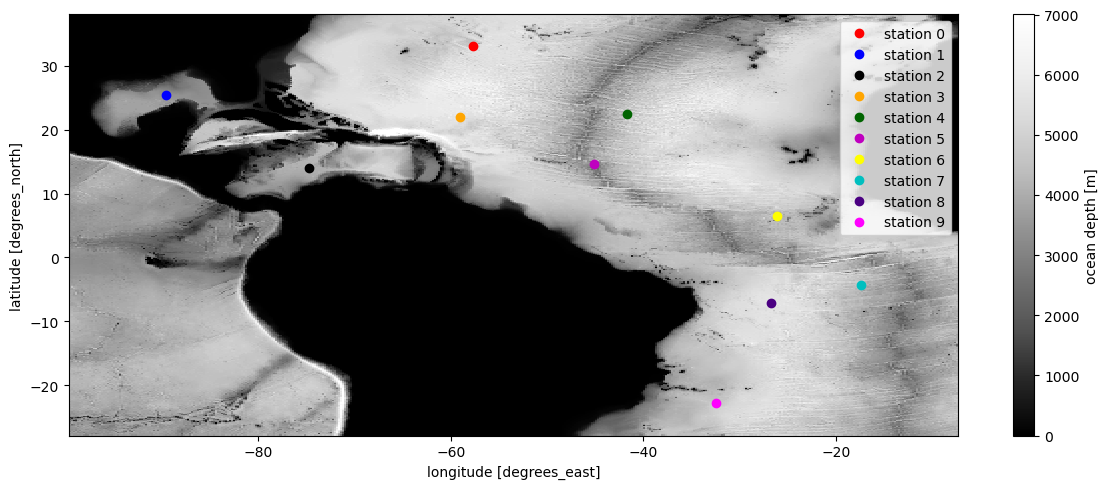

In [8]:
fig = plt.figure(figsize=(12, 5))
ax = cut_od.plot.horizontal_section(varName="Depth", cmap='Greys_r', **plt_kwargs)
colors=['r', 'b', 'k', 'orange', 'darkgreen', 'm', 'yellow', 'c', 'indigo', 'magenta', 'green']
legestations_ds = np.arange(Nstations)
for i in range(Nstations):
    plt.plot(lons[i], lats[i], 'o', color=colors[i], label='station ' + str(legestations_ds[i]))
plt.legend();
plt.show()

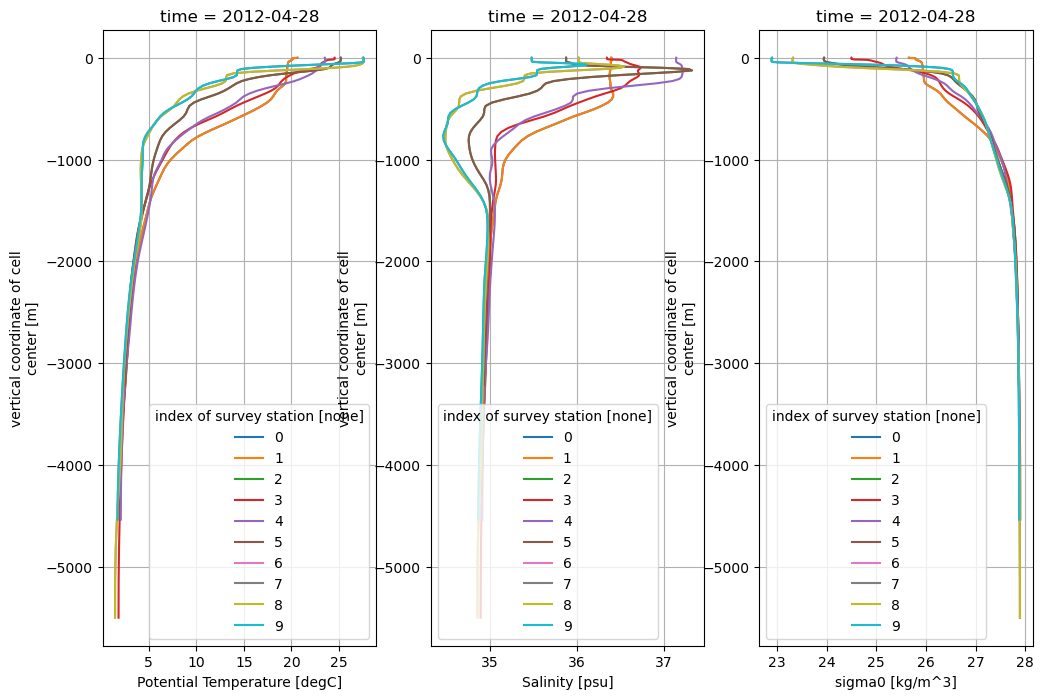

In [9]:
# plot vertical profiles...
plt.subplot(1,3,1)
stations_ds._ds['Temp'].squeeze().plot.line(y="Z")
plt.grid()
plt.subplot(1,3,2)
stations_ds._ds['S'].squeeze().plot.line(y="Z")
plt.grid()
plt.subplot(1,3,3)
stations_ds._ds['sigma0'] = ospy.utils.densjmd95(stations_ds["S"],stations_ds["Temp"],0) - 1000.0
stations_ds._ds.sigma0.attrs['units'] = 'kg/m^3'
stations_ds._ds['sigma0'].squeeze().plot.line(y="Z")
plt.grid()
plt.show()

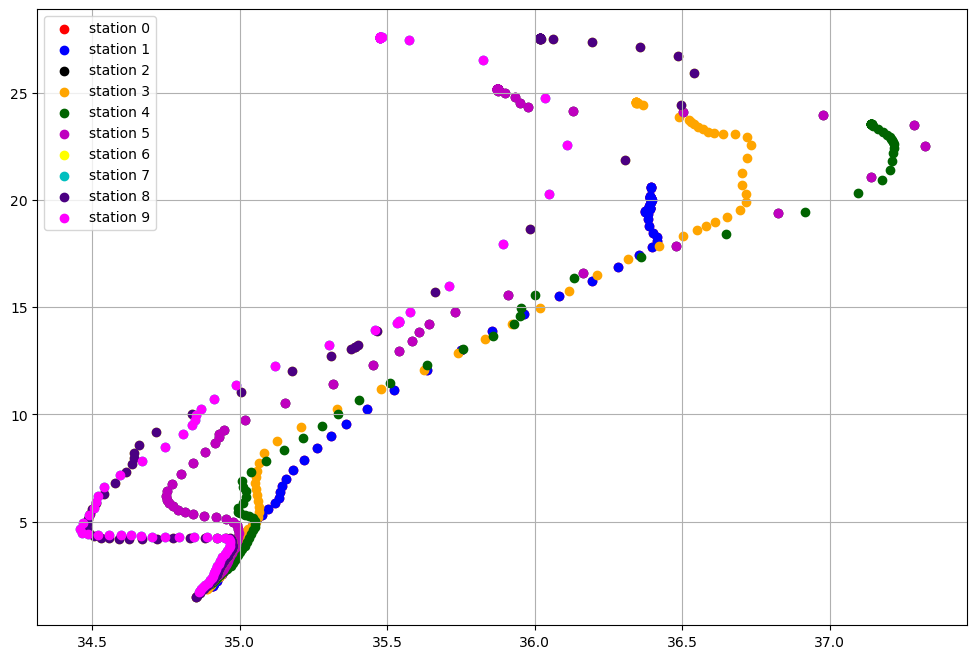

In [10]:
# plot TS diagram. For LLC4320 this takes a while....
for i in range(Nstations):
    plt.scatter(stations_ds["S"].isel(station = i),stations_ds["Temp"].isel(station = i), color=colors[i], label='station ' + str(legestations_ds[i]))
plt.legend();
plt.grid()
plt.show()